### image clustering

use venv N2D

https://arxiv.org/pdf/1908.05968.pdf

https://n2d.readthedocs.io/en/latest/quickstart.html#building-the-model

see also:

https://github.com/sudiptodip15/ClusterGAN

https://github.com/zhampel/clusterGAN

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2";  

In [2]:
import os
import urllib3

import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from pathlib import Path
from PIL import Image
from skimage import color
from skimage import io
import n2d

Using TensorFlow backend.
/home/walle/.virtualenvs/N2D/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


### caribbean 

load as greyscale

In [3]:
img_size=64

In [4]:
data_dir = Path('../data')

In [5]:
train_images=data_dir/f'train/rotated/clipped/reflect/{img_size}'
test_images=data_dir/f'test/rotated/clipped/reflect/{img_size}'

### dataset

In [6]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [7]:
df_valid=df_all.loc[df_all['verified'] == False]

In [8]:
len(df_all)

22553

In [9]:
len(df_valid)

7683

In [10]:
df_valid=df_valid.drop_duplicates(subset=['id'])

In [11]:
file_list= df_valid['id'].values.tolist()

In [12]:
def get_caribbean_images(file_list):
    images=[]
    names=[]
    for img in train_images.iterdir():
        if str(img).endswith('.tif'):
            name = str(img).split('/')[-1]
            name = name.split('.tif')[0]
            if name in file_list:
                names.append(name)
                im = Image.open(img).convert('L')
                in_data = np.asarray(im, dtype=np.uint8)
                images.append(in_data)
    np_img=np.array(images)
    return np_img, names
    

In [13]:
np_x, names=get_caribbean_images(file_list)

In [14]:
np_x.shape

(7683, 64, 64)

In [15]:
names[0]

'7a2723c0'

In [16]:
np_x = np_x.reshape((np_x.shape[0], -1))

#### categories

In [17]:
def get_image_cats(names):
    categories=[]
    for im_id in names:
        cat = df_valid.loc[df_valid['id'] == im_id, 'roof_material']
        categories.append(str(cat).split()[1])
    return categories

In [18]:
categories=get_image_cats(names)

In [19]:
n_cl_caribbean=len(list(set(categories)))

In [20]:
n_cl_caribbean

4

In [21]:
df_valid["roof_material"] = df_valid["roof_material"].astype('category')

In [22]:
df_valid["roof_codes"] = df_valid["roof_material"].cat.codes

In [23]:
df_valid["roof_codes"]=df_valid["roof_codes"]+1

In [24]:
df_valid.head()

,id,roof_material,verified,country,region,roof_codes
13866,7a24bd7e,healthy_metal,False,st_lucia,castries,2
13867,7a2cf00c,healthy_metal,False,st_lucia,castries,2
13868,7a3975e8,healthy_metal,False,st_lucia,castries,2
13869,7a1d215e,healthy_metal,False,st_lucia,castries,2
13870,7a42475e,healthy_metal,False,st_lucia,castries,2


In [25]:
y = df_valid['roof_codes'].values.tolist()

In [40]:
df_valid['roof_codes'].unique()

array([2, 1, 4, 3])

In [41]:
df_valid['roof_material'].unique()

[healthy_metal, concrete_cement, other, incomplete]
Categories (4, object): [healthy_metal, concrete_cement, other, incomplete]

In [26]:
len(y)

7683

In [27]:
wts_dir = Path('weights')
wts_dir.mkdir(exist_ok=True)

In [28]:
np_x.shape

(7683, 4096)

In [29]:
type(np_x[0])

numpy.ndarray

In [30]:
carribbean_cl = n2d.n2d(np_x, nclust = n_cl_caribbean)

n2d.__init__() shape: [4096, 500, 500, 2000, 4], architecture: [500, 500, 2000]
AutoEncoder.__init__() dims: 5
AutoEncoder.__init__() x: (None, 4096)
AutoEncoder.__init__() n_stacks: 4
AutoEncoder.__init__() i: 0
AutoEncoder.__init__() i: 1
AutoEncoder.__init__() i: 2
AutoEncoder.__init__() pre Dense h: (None, 2000)
AutoEncoder.__init__() post Dense h: (None, 4096)
n2d.__init__() hidden: (None, 4)


### Train

In [31]:
#carribbean_cl.preTrainEncoder(pretrain_epochs = 100, weight_id = 'train_invalid_64')

#### load pre-trained

<pre>
preTrainEncoder(self,batch_size = 256, pretrain_epochs = 1000,
                     loss = 'mse', optimizer = 'adam',weights = None,
                     verbose = 0, weight_id = 'generic_autoencoder'):
    </pre>

In [32]:
carribbean_cl.preTrainEncoder(weights=wts_dir/'train_invalid_64-100-ae_weights.h5')

### predict clusters

In [33]:
manifold_cluster = n2d.UmapGMM(n_cl_caribbean)
carribbean_cl.predict(manifold_cluster)

/home/walle/.virtualenvs/N2D/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../home/walle/.virtualenvs/N2D/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/walle/.virtualenvs/N2D/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../..

In [34]:
y[0]

2

In [35]:
len(y)

7683

In [36]:
print(carribbean_cl.assess(y))

best_cluster_fit y_true: (7683,), y_pred: (7683,)
(0.35598, 0.00136, 0.00025)


/home/walle/.virtualenvs/N2D/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/walle/.virtualenvs/N2D/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [37]:
ids=df_valid['id'].values.tolist()

saving figure to: viz/caribbean_invalid-n2d.png


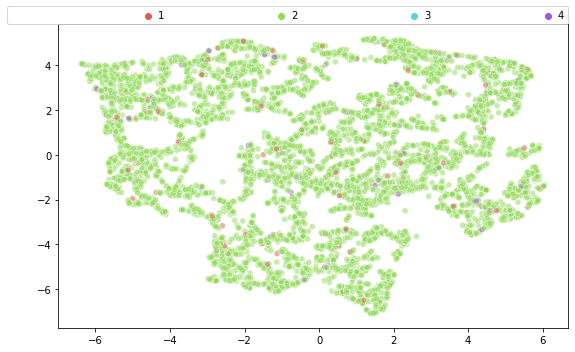

best_cluster_fit y_true: (7683,), y_pred: (7683,)
saving figure to: viz/caribbean_invalid-n2d-predicted.png


/home/walle/.virtualenvs/N2D/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


<Figure size 432x288 with 0 Axes>

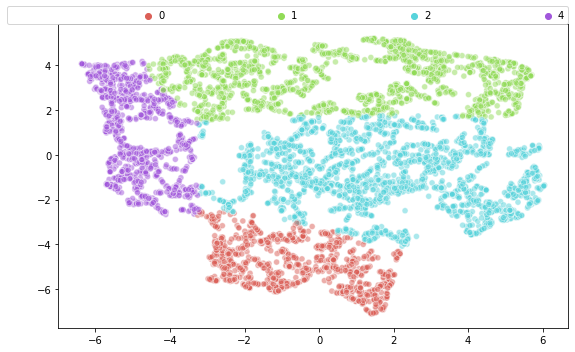

<Figure size 432x288 with 0 Axes>

In [38]:
carribbean_cl.visualize(y, names=None, dataset = "caribbean_invalid", nclust = n_cl_caribbean, first_n_pts=7683, ids=ids)


Overrepresentation of healthy metal

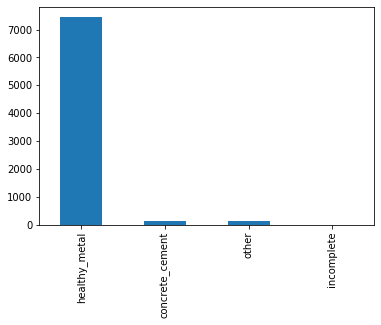

In [39]:
df_valid['roof_material'].value_counts().plot(kind='bar')